In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [15]:
# create the inspector and connect to the engine
inspector_gadget = inspect(engine)

tables = inspector_gadget.get_table_names()
for table in tables:
    print(table)
    
    # get all columns in table
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column)
    print()

measurement
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}

station
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoi

In [16]:
query = "SELECT * from measurement ORDER BY date DESC LIMIT 20;"
df = pd.read_sql(query, engine)
df.head()

,id,station,date,prcp,tobs
0,2724,USC00519397,2017-08-23,0.00,81.0
1,7635,USC00514830,2017-08-23,0.00,82.0
2,12187,USC00519523,2017-08-23,0.08,82.0
3,19550,USC00516128,2017-08-23,0.45,76.0
4,2723,USC00519397,2017-08-22,0.00,82.0


In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
prec_data = session.query(measurement.date,func.avg(measurement.prcp)).\
    filter(measurement.date>=query_date).\
    group_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prec_data, columns = ['date', 'prcp'])
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace =True)

# Sort the dataframe by date
df.sort_values('date')

df.head()

,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


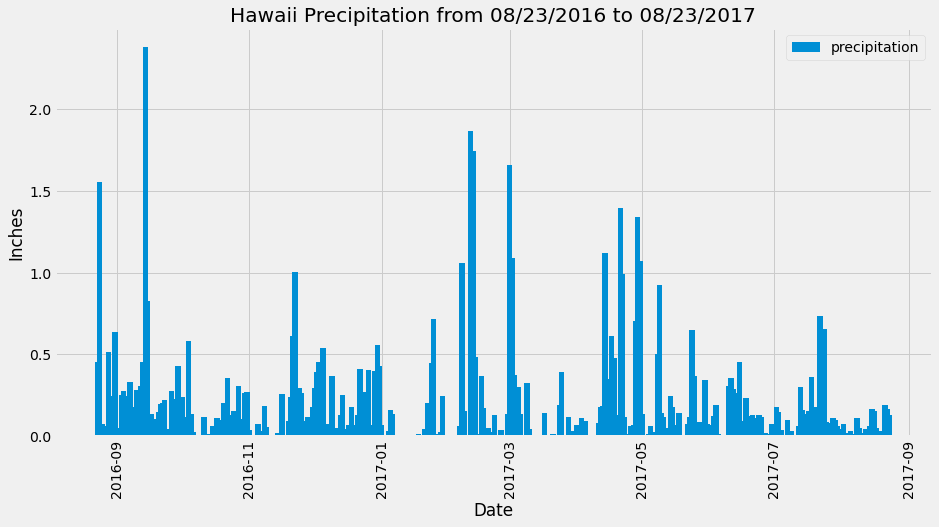

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(14, 7))

plt.bar(df.index,df.prcp,width=2.5)
plt.xticks(rotation=90)
plt.title('Hawaii Precipitation from 08/23/2016 to 08/23/2017')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.legend(['precipitation'])

plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(func.count(station.station)).scalar()
stations

9

In [22]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(station.station, station.name,func.count(station.station)).\
    filter(station.station == measurement.station).\
    group_by(station.station).order_by(func.count(station.station).desc()).all()
active_stations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
low = session.query(func.min(measurement.tobs)).\
    filter(station.station == measurement.station).\
    filter(station.name == 'WAIHEE 837.5, HI US').scalar()

high = session.query(func.max(measurement.tobs)).\
    filter(station.station == measurement.station).\
    filter(station.name == 'WAIHEE 837.5, HI US').scalar()

avg = session.query(func.avg(measurement.tobs)).\
    filter(station.station == measurement.station).\
    filter(station.name == 'WAIHEE 837.5, HI US').scalar()

print(f'The lowest temperature: {low}')
print(f'The highest temperature: {high}')
print(f'The average temperature: {avg}')

The lowest temperature: 54.0
The highest temperature: 85.0
The average temperature: 71.66378066378067


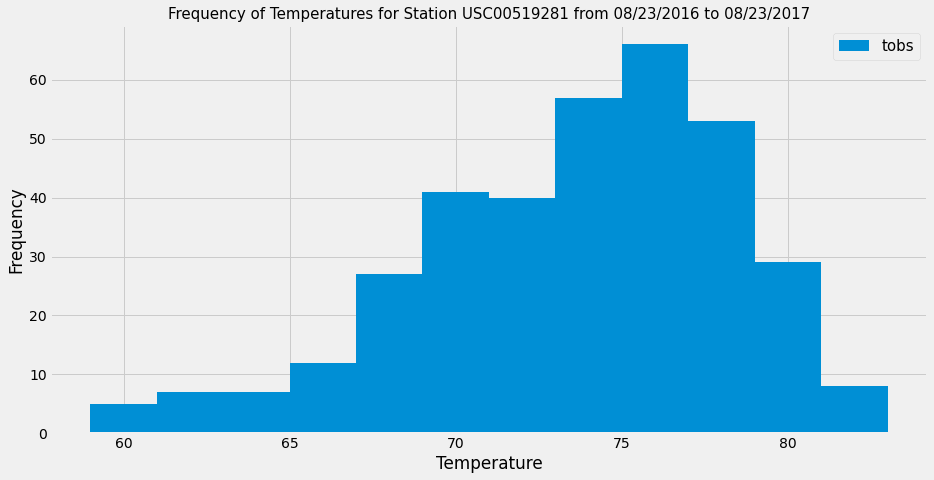

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(measurement.tobs).\
    filter(measurement.date>='2016-08-23').\
    filter(station.station == measurement.station).\
    filter(station.name == 'WAIHEE 837.5, HI US').all()

# Converting query to list for graphing
temp_list = [t[0] for t in temps]

fig1, ax1 = plt.subplots(figsize=(14, 7))
plt.hist(temp_list, 12, label = 'tobs')
plt.title('Frequency of Temperatures for Station USC00519281 from 08/23/2016 to 08/23/2017', fontsize = 15)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(fontsize = 15)
plt.show()

# Close session

In [28]:
# Close Session
session.close()